# Energy-dependent third-factor STDP

Lets bombard one edlif neuron with multiple poisson processes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import re
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential. Let's download the model from the NESTML repository so it becomes available locally:

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [2]:
module_name = "edlif_psc_alpha_0_module"
nest.Install(module_name)


Oct 05 14:07:12 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


In [9]:
def experiment(seed: int = 1,
              poisson_rate: float = 100,
              n_pre_neurons: int = 1000,
              mean_current: float = 545,
              std_current: float = 40,
              neuron_model: str = "edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml",
              syn_spec: dict = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
                               "alpha": 0.5,
                               "mu_minus": 0,
                               "mu_plus": 0,
                               "lambda": 0.01,
                               "eta": 20},
              sim_time: float = 2000):
    # reset kernel
    nest.ResetKernel()
    # set seeds
    nest.rng_seed = seed
    np.random.seed(seed)
    # create neurons
    neuron_post = nest.Create(neuron_model)
    neuron_pre = nest.Create(neuron_model, n_pre_neurons)
    # set neurons params
    for n in neuron_pre:
        n.I_e = np.random.normal(mean_current, std_current)
    #neuron_pre = nest.Create("poisson_generator", {"rate": poisson_rate})
    for neuron in [neuron_pre, neuron_post]:
        neuron.tau_m = 20 #20
        neuron.tau_syn_ex = 6
        neuron.tau_syn_in = 6
        neuron.C_m = 250 #250
        neuron.t_ref = 8 #2
        # energy params
        neuron.K_ATP = 1
        neuron.gamma = 178
        neuron.tau_ap = 100
        neuron.E_ap = 8
        neuron.E_rp = 5
        neuron.E_hk = 5
        neuron.E_syn_ex = 4
        neuron.E_syn_in = 4
        neuron.tau_syn_atp_ex = 100
        neuron.tau_syn_atp_ex = 100

    
    # recorders
    sr_post = nest.Create("spike_recorder")
    nest.Connect(neuron_post, sr_post)
    sr_pre = nest.Create("spike_recorder")
    nest.Connect(neuron_pre, sr_pre)
    mult = nest.Create('multimeter',
                      params={"record_from": ["ATP"]})
    nest.Connect(mult, neuron_post)
    wr = nest.Create("weight_recorder")
    nest.CopyModel(syn_spec["synapse_model"], "w_record", 
                  {"weight_recorder": wr})
    nest.Connect(neuron_pre, neuron_post, 
                 syn_spec={"synapse_model": "w_record"})
    syn = nest.GetConnections(source=neuron_pre,
                         target=neuron_post,
                         synapse_model="w_record")
    #print(syn)
    for param, value in syn_spec.items():
        if param != "synapse_model":
            nest.SetStatus(syn, {param: value})
    nest.Simulate(sim_time)
    sr_pre = sr_pre.get("events")
    sr_post = sr_post.get("events")
    mult = mult.get("events")
    wr = wr.get("events")
    fin_weights = nest.GetConnections(source=neuron_pre,
                                     target=neuron_post)
    return sr_pre, sr_post, mult, wr, fin_weights.get('w')

In [10]:
def plots(sr_pre, sr_post, mult, wr, eta, fin_weights):
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ID")
    plt.plot(sr_pre['times'], sr_pre['senders'], '.', alpha=0.5)

    plt.figure()
    plt.title(fr"$\eta$ = {eta}") 
    plt.xlabel("time (ms)")
    plt.ylabel("ID")
    plt.plot(sr_post['times'], sr_post['senders'], '.', alpha=0.5)

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ATP")
    plt.plot(mult['times'], mult['ATP'])

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Weights")
    plt.plot(wr['times'], wr['weights'], '.')

    plt.figure()
    plt.xlabel("Weights")
    plt.ylabel("Frequency")
    plt.title(fr"$\eta$ = {eta}")
    plt.hist(fin_weights)
    
    #plt.show()
    #plt.close(fig)
    


Oct 05 14:09:57 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:09:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 05 14:10:04 SimulationManager::run [Info]: 
    Simulation finished.


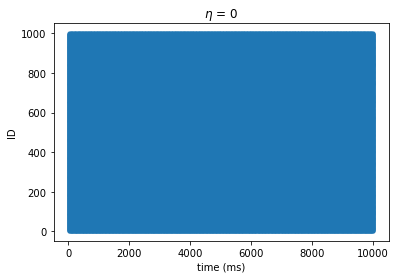

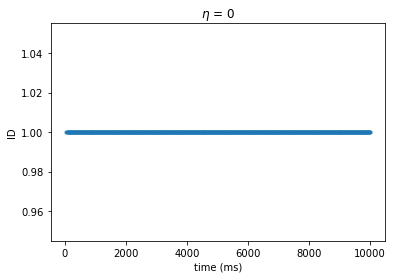

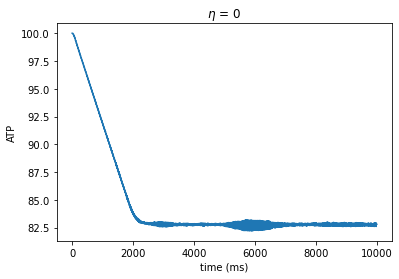

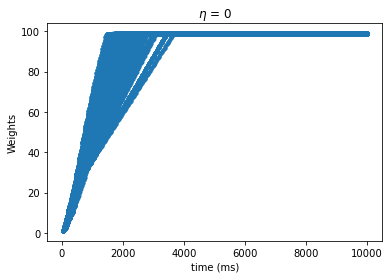

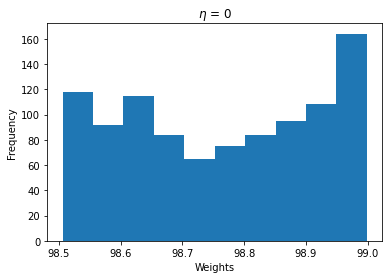

In [18]:
sim_time = 10000
eta = 0
#n_pre_neurons = 2
mean_current = 292
std_current = 10
syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
           "alpha": 0.5,
           "mu_minus": 0,
           "mu_plus": 0,
           "lambda": 0.01,
           "eta": eta}
sr_pre, sr_post, mult, wr, fin_weights = experiment(
                                       #n_pre_neurons=n_pre_neurons,
                                       mean_current=mean_current,
                                       std_current=std_current,
                                       sim_time=sim_time,
                                       syn_spec=syn_spec)

plots(sr_pre, sr_post, mult, wr, eta, fin_weights)


Oct 05 14:26:09 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:09 SimulationManager::start_updating_ [Info]: 
Results for eta = 0    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 05 14:26:16 SimulationManager::run [Info]: 
    Simulation finished.


Oct 05 14:26:16 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 05 14:26:23 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 1

Oct 05 14:26:24 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 

/tmp/ipykernel_27790/393025072.py:2: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Oct 05 14:26:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 05 14:26:52 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 50

Oct 05 14:26:53 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

Oct 05 14:26:59 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 100

Oct 05 14:26:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Oct 05 14:26:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 10000
    Number of OpenMP threads: 1
    Not using MPI

O

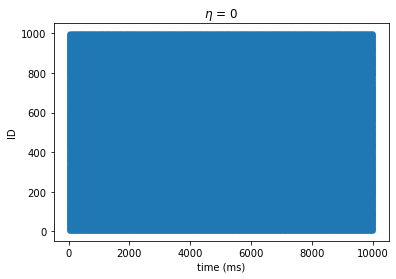

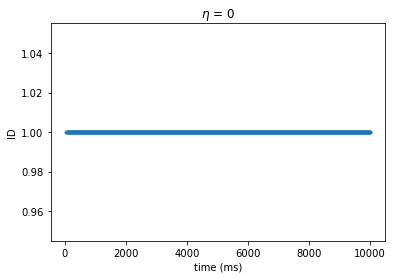

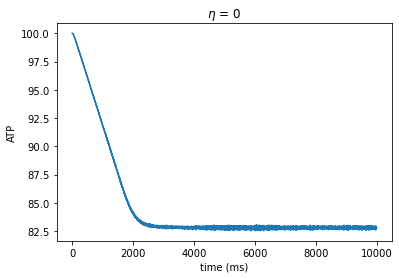

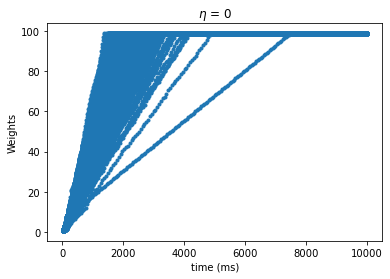

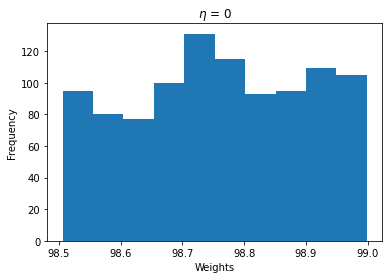

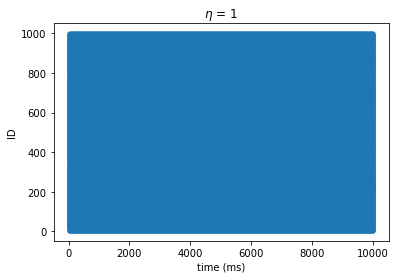

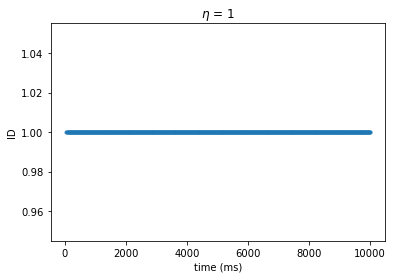

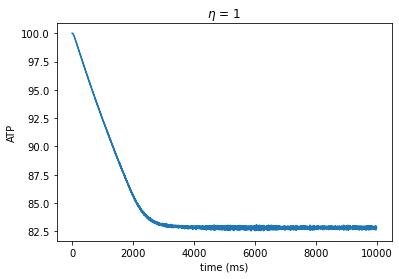

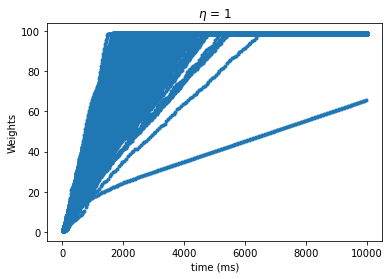

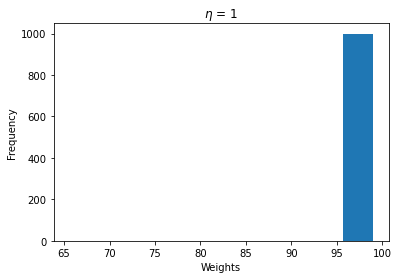

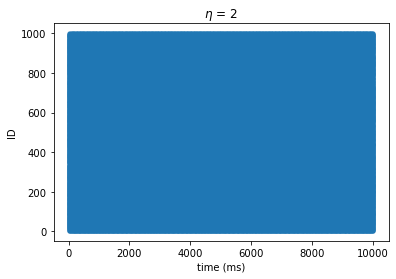

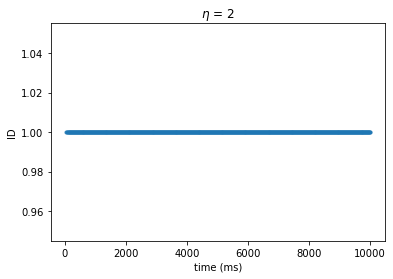

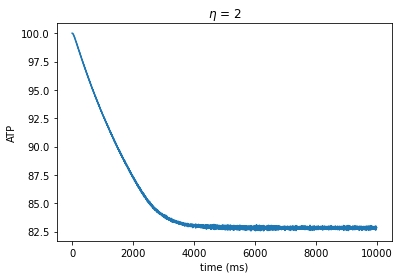

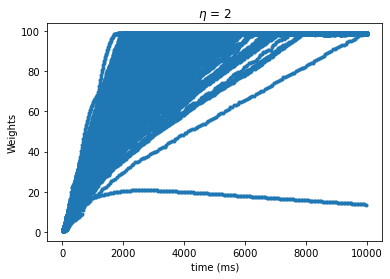

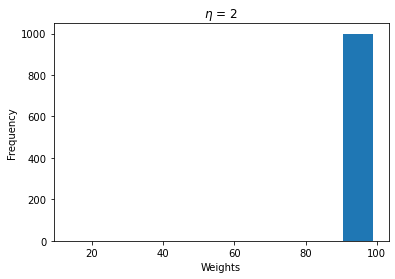

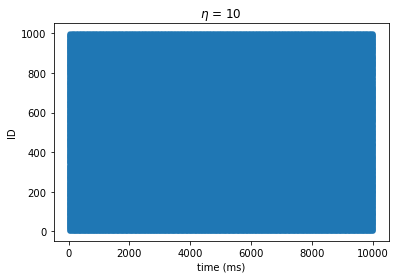

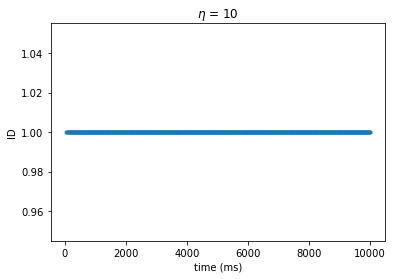

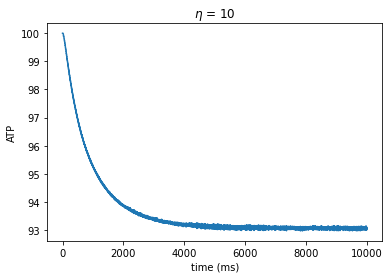

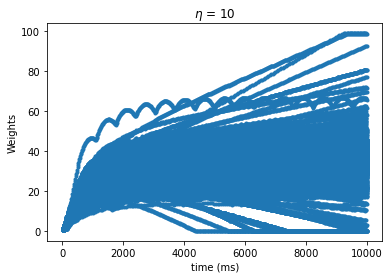

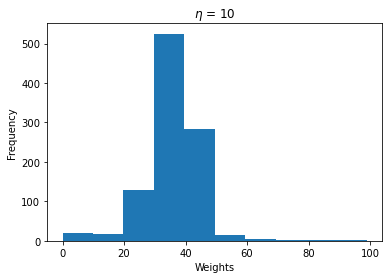

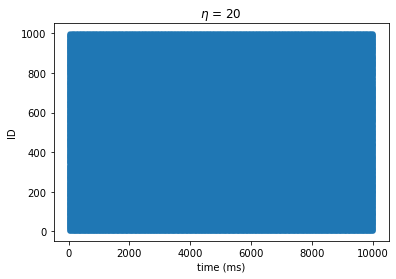

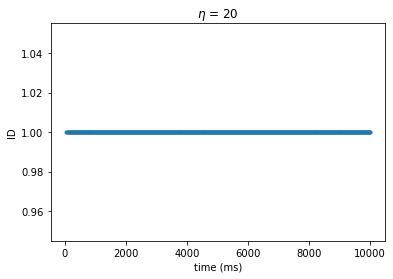

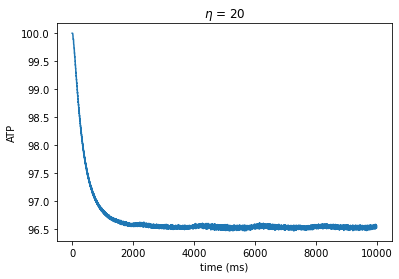

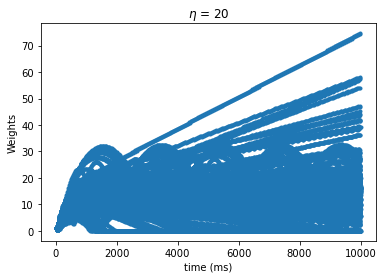

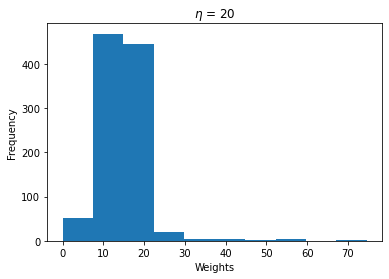

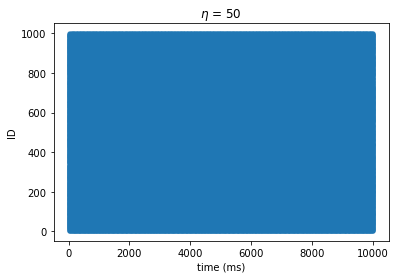

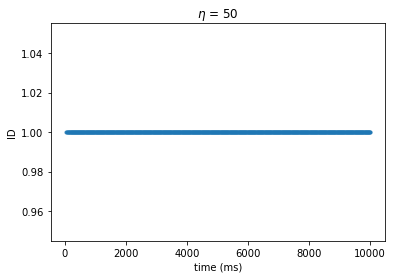

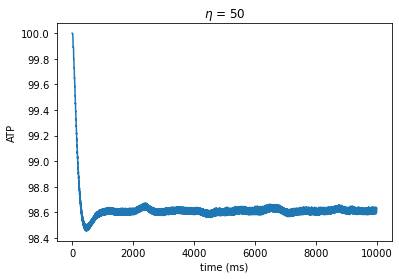

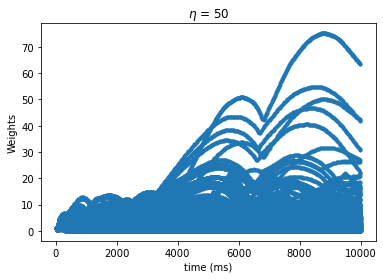

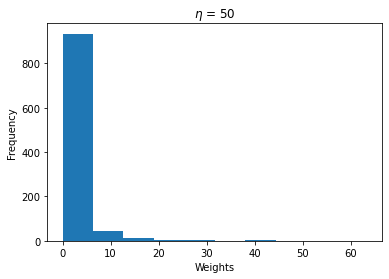

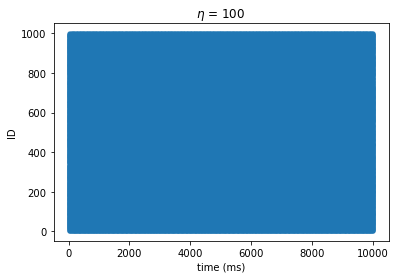

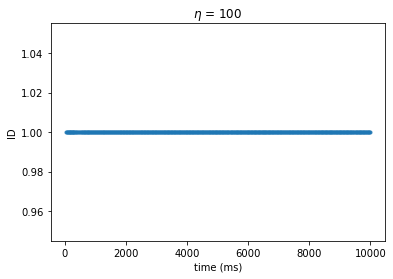

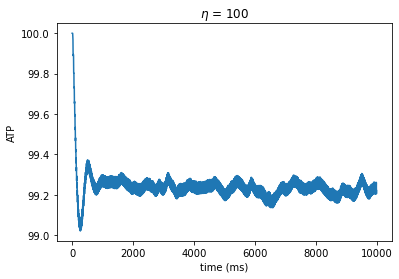

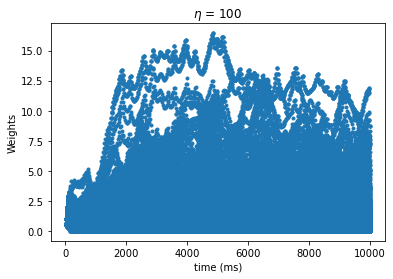

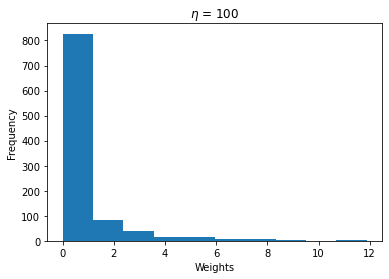

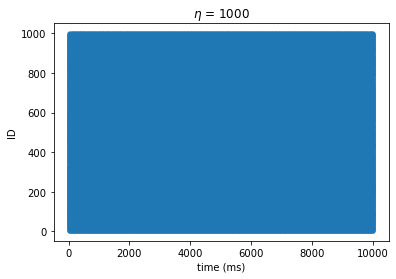

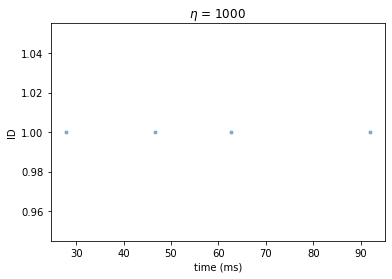

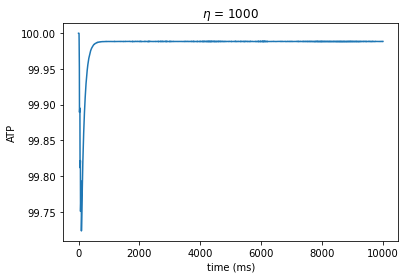

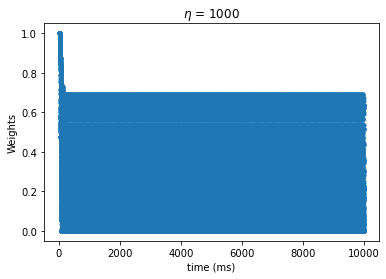

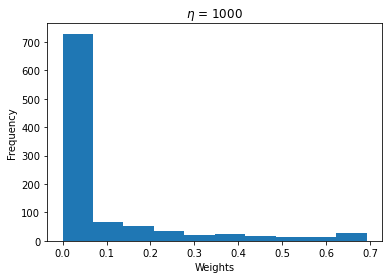

In [25]:
sim_time = 10000
mean_current = 292
std_current = 30
etas = [0, 1, 2, 10, 20, 50, 100, 1000]
mult_tot = []
wr_tot = []
fin_weights_tot = []
for eta in etas:
    syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
               "alpha": 0.5,
               "mu_minus": 0,
               "mu_plus": 0,
               "lambda": 0.01,
               "eta": eta}
    sr_pre, sr_post, mult, wr, fin_weights = experiment(
                                       sim_time=sim_time,
                                       mean_current=mean_current,
                                       std_current=std_current,
                                       syn_spec=syn_spec)
    mult_tot.append(mult)
    wr_tot.append(wr)
    fin_weights_tot.append(fin_weights)
    print(f"Results for eta = {eta}")
    plots(sr_pre, sr_post, mult, wr, eta, fin_weights)

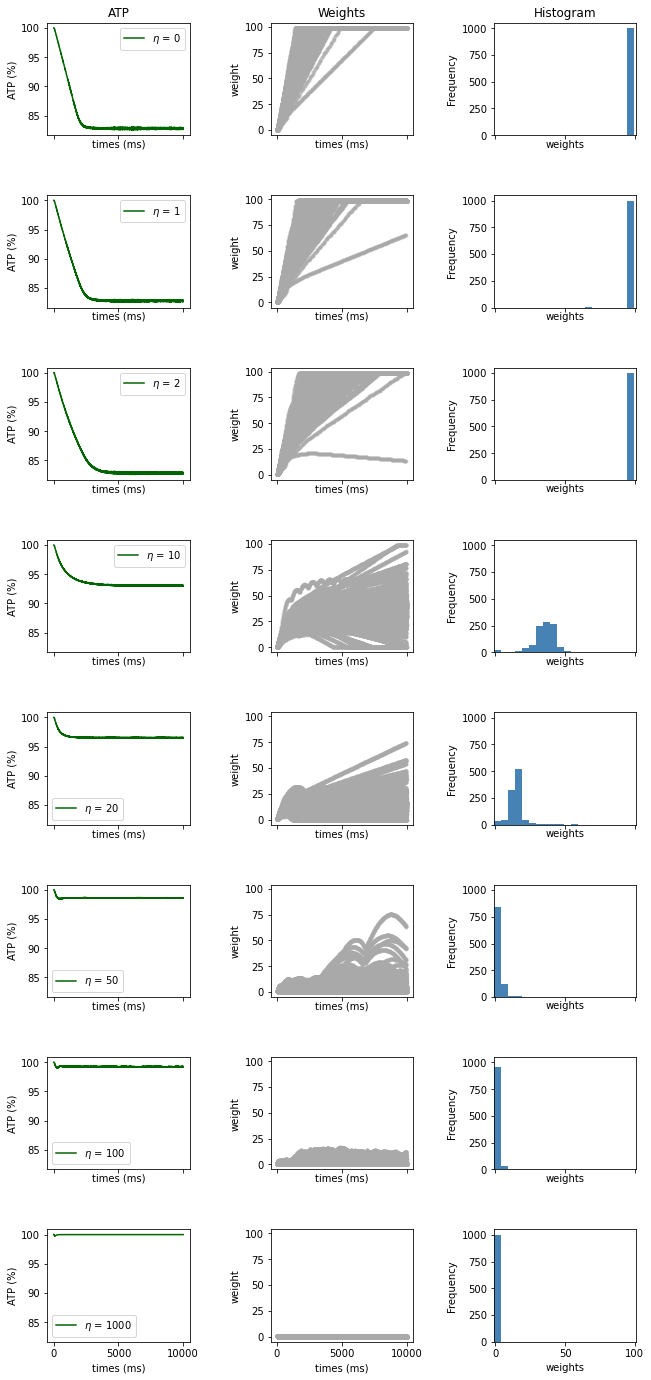

In [56]:
#mult_tot.append(mult)
#wr_tot.append(wr)
#fin_weights_tot.append(fin_weights)
bins = np.arange(-1, 101, 5)
fig, ax = plt.subplots(len(etas), 3, figsize=(10, 20), 
                       sharex='col', sharey='col')
fig.tight_layout(pad=5.0)
for row, eta in enumerate(etas):
    for_plot = [mult_tot[row], wr_tot[row], fin_weights_tot[row]]
    for col in range(3):
        if col == 0:
            ax[row, col].plot(mult_tot[row]['times'], 
                              mult_tot[row]['ATP'],
                             label=f'$\eta$ = {eta}',
                             color='darkgreen')
            ax[row, col].set_xlabel('times (ms)')
            ax[row, col].set_ylabel('ATP (%)')
            ax[row, col].legend()
            if row == 0:
                ax[row, col].set_title('ATP')
                
        elif col == 1:
            ax[row, col].plot(wr_tot[row]['times'], 
                              wr_tot[row]['weights'], '.',
                             color='darkgrey',
                             alpha=0.5)
            ax[row, col].set_xlabel('times (ms)')
            ax[row, col].set_ylabel('weight')
            if row == 0:
                ax[row, col].set_title('Weights')
                
        else:
            ax[row, col].hist(fin_weights_tot[row],
                             bins=bins,
                             facecolor='steelblue')
            ax[row, col].set_xlim(-1, 101)
            ax[row, col].set_xlabel('weights')
            ax[row, col].set_ylabel('Frequency')
            if row == 0:
                ax[row, col].set_title('Histogram')

In [20]:
print(set(sr_pre['senders']))
print('--------------')
print('total senders:')
print(len(set(sr_pre['senders'])))

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

In [21]:
def drift_classic(alpha, tau, r, delta_t):
    if delta_t > 0:
        drift = (1-alpha)*tau*r**2 + r*np.exp(-delta_t/tau)
    else:
        drift = (1-alpha)*tau*(r**2) - alpha*r*np.exp(delta_t/tau)
    
    if drift > 0:
        drift = 1
    else:
        drift = 0
        
    return drift

In [22]:
def drift_classic(alpha, tau, r, delta_t):
    f_p = 1
    f_m = alpha
    T_p = r**(-1) * np.exp(-abs(delta_t)/tau) * (delta_t > 0)
    T_m = r**(-1) * np.exp(-abs(delta_t)/tau) * (delta_t < 0)
    drift = r**2*((f_p-f_m)*tau + f_p * T_p - f_m * T_m)
    return drift

In [23]:
delta_t = np.linspace(-200, 200, 500)  # ms
alpha = 0.95
tau = 10  
r = 1  # Hz
lambd = 0.005
drift_c = []
samples = 40
w_init = 0.5
for d_t in delta_t:
    drift_per_dt = []
    w_init = 0.5
    for n in range(samples):
        dt = d_t
        drift_per_dt.append(drift_classic(
                                 alpha=alpha,
                                 tau=tau,
                                 delta_t=dt,
                                 lambd=lambd,
                                 w=w_init))
        w_init = drift_per_dt[-1]
    mean_drift = np.mean(drift_per_dt)
    #drift_c.append(drift_per_dt)
    drift_c.append(mean_drift)

TypeError: drift_classic() got an unexpected keyword argument 'lambd'

In [ ]:
plt.plot(delta_t, drift_c)

In [ ]:
def stdp(alpha, tau, delta_t, lambd):
    if delta_t > 0:
        dw = lambd * np.exp(-delta_t/tau)
    else:
        dw = -lambd * alpha * np.exp(delta_t/tau)
    return dw

In [ ]:
alpha = 0.95
#alpha = 1.05
tau = 10  
lambd = 0.005

pre_spikes = np.linspace(200, 400, 20)
delta_t = np.linspace(-200, 200, 400)
mean_w = []
w_init = 0
r = len(pre_spikes)/(pre_spikes[-1] - pre_spikes[0])*1000
print(f'firing rate: {r}')
for dt in delta_t:
    post_spikes = pre_spikes + dt
    dw = []
    for post_s in post_spikes:
        for n, pre_s in enumerate(pre_spikes[0: n+1]):
            dw.append(stdp(
                            alpha=alpha,
                            tau=tau,
                            lambd=lambd,
                            delta_t=post_s-pre_s))
            #dw.append(drift_classic(
            #                     alpha=alpha,
            #                     tau=tau,
            #                     r=r,
            #                     delta_t=(post_s-pre_s)))
    tot_dw = np.sum(dw)
    #mean_w.append(max(0, min(1, w_init + np.mean(dw))))
    mean_w.append(max(0, min(1, w_init + tot_dw)))
    
            

In [ ]:
plt.plot(delta_t, mean_w)

In [ ]:
pre_spikes

In [ ]:
post_spikes